# Submission

- submission for single model 
- top-view model => successful PB 0.63

In [1]:
#--
import sys
sys.path.append("/mnt/hdd/eric/.tmp_ipy/15.Lab_Detection/07.Challenge/01.MapYourCity_HuggingFace")
import map_dataset
import map_train
from models import *

sys.path.append("/mnt/hdd/eric/.tmp_ipy/15.Lab_Detection/00.Libs")
import RS_dataset
import RS_models
import RS_utils
#--- torch
import torch
from torch.utils.data import DataLoader
from torch.optim import AdamW
from torch.optim.lr_scheduler import StepLR
#--- loss functions
from utils.losses import LabelSmoothCrossEntropy, CrossEntropyLoss
from torch.cuda.amp import GradScaler, autocast
#---
from lightning.fabric import Fabric
from lightning.fabric.loggers import CSVLogger, TensorBoardLogger
from torchmetrics.classification import Accuracy
import pandas as pd 
import os 
from sklearn.model_selection import train_test_split
import argparse
import yaml 
import timm
import numpy as np 
import time
import wandb
import random
import matplotlib.pyplot as plt
from rich.console import Console

INFO:albumentations.check_version:A new version of Albumentations is available: 1.4.10 (you have 1.4.8). Upgrade using: pip install --upgrade albumentations
/mnt/hdd/eric/.conda/envs/mapv2/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#--- all infos
inference_dict ={
    'models':[],
    'cfgs':[],
    'predictions':[],
    'labels':[]
}

#--- argparser
cfgs_names = ['finetune_5.yaml', 'finetune_8.yaml']
for cfg_name in cfgs_names:    
    parser = argparse.ArgumentParser()
    parser.add_argument('--cfg', type=str, default=os.path.join('./configs', cfg_name))
    args = parser.parse_args(args=[])
    cfg = argparse.Namespace(**yaml.load(open(args.cfg), Loader=yaml.SafeLoader))
    inference_dict['cfgs'].append(cfg)
    print("Model run version : ", cfg.RUN_VERSION)

Model run version :  15
Model run version :  18


In [3]:
#--- Data 
input_path = "/mnt/hdd/eric/.tmp_ipy/00.Data/Map_Your_City/building-age-dataset/"
train_path = input_path + "train/data/"
test_path = input_path + "test/data/"
train_df = pd.read_csv(input_path + "train/train-set.csv")
test_df = pd.read_csv(input_path + "test/test-set.csv") 

#--- data split 
names_data = os.listdir(train_path)
names_train, names_valid = train_test_split(names_data, test_size=0.1, random_state=1)

In [4]:
for cfg in inference_dict['cfgs']:   
    model = timm.create_model(
    cfg.MODEL,
    pretrained=True,
    num_classes=cfg.CLASSES_NUM )

    #--- data config and transform
    data_config = timm.data.resolve_model_data_config(model)
    data_transform = timm.data.create_transform(**data_config, is_training=False)

    inference_dict['models'].append(model)
    print("#------------------------------------")
    print(" Model Name : ",cfg.MODEL)

/mnt/hdd/eric/.conda/envs/mapv2/lib/python3.8/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/eva02_base_patch14_448.mim_in22k_ft_in22k_in1k)
INFO:timm.models._hub:[timm/eva02_base_patch14_448.mim_in22k_ft_in22k_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.


#------------------------------------
 Model Name :  eva02_base_patch14_448.mim_in22k_ft_in22k_in1k


INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/eva02_base_patch14_448.mim_in22k_ft_in22k_in1k)
INFO:timm.models._hub:[timm/eva02_base_patch14_448.mim_in22k_ft_in22k_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.


#------------------------------------
 Model Name :  eva02_base_patch14_448.mim_in22k_ft_in22k_in1k


In [5]:
ckpt_paths = [
            "/mnt/hdd/eric/.tmp_ipy/15.Lab_Detection/07.Challenge/01.MapYourCity_HuggingFace/output/15_eva02_base_patch14_448.mim_in22k_ft_in22k_in1k_f1_0.65_epoch_8.pth",
            "/mnt/hdd/eric/.tmp_ipy/15.Lab_Detection/07.Challenge/01.MapYourCity_HuggingFace/output/18_eva02_base_patch14_448.mim_in22k_ft_in22k_in1k_f1_0.7226_epoch_5.pth" ]

for i,model in enumerate(inference_dict['models']):
    model.load_state_dict(torch.load(ckpt_paths[i]))

In [6]:
train_set = map_dataset.Map_Dataset_v7(names_train,train_path,max_size=data_config['input_size'][1],cfg=cfg,split="valid") 
valid_set = map_dataset.Map_Dataset_v7(names_valid,train_path,max_size=data_config['input_size'][1],cfg=cfg,split="valid")  

idx :  335


1 < Label > 
1 < 1 Model Prediction > 
tensor([[6.2402e-05, 9.9988e-01, 1.3332e-05, 5.1543e-06, 3.1152e-06, 3.5057e-06,
         3.7091e-05]], device='cuda:3', grad_fn=<SoftmaxBackward0>)


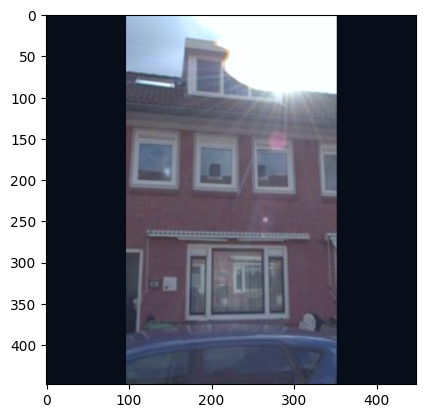

In [7]:
'''
#--- Single image for Visualization 
# A model : Cross-entropy loss with Street Voew 
# B model : Cross-entropy loss with Top Voew

'''
idx_ = random.randint(0,999)
print("idx : ", idx_)

dataset = valid_set

street_view = dataset.__getitem__(idx_)[0]
img_torch = street_view 
#RS_utils.torch_display(img_torch, False, True)

#--- inference
device = "cuda:3"


def infer_model(img_torch,model,loss_type):
    
    img_torch = img_torch.to(device)
    
    model = model.eval()
    model = model.to(device)
    img_torch = img_torch.unsqueeze(0)
    preds = model(img_torch)
    
    if loss_type == "CE":
        preds_ = preds.softmax(-1).argmax(-1)
    elif loss_type == "MSE" or loss_type == "MAE":
        preds_ = preds
    print(dataset.__getitem__(idx_)[-1], "< Label > ")
    print(preds_.item(), f"< {i} Model Prediction > ")
    #print(preds)
    print(preds.softmax(-1))
    
    img_torch = img_torch.squeeze(0)
    img = img_torch.clone() 
    
    # denormal
    img = ((img) * 0.22) + 0.5
    # [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
    #-----
            
    img = img.permute(1,2,0).cpu()
    img = np.asarray(img)   
    plt.imshow(img)
        
            
#-- 
infer_model(img_torch,inference_dict['models'][0],"CE")

1 < Label > 
1 < 1 Model Prediction > 
tensor([[1.6565e-03, 9.9663e-01, 4.2564e-04, 3.0264e-04, 2.3410e-04, 2.5849e-04,
         4.9260e-04]], device='cuda:3', grad_fn=<SoftmaxBackward0>)


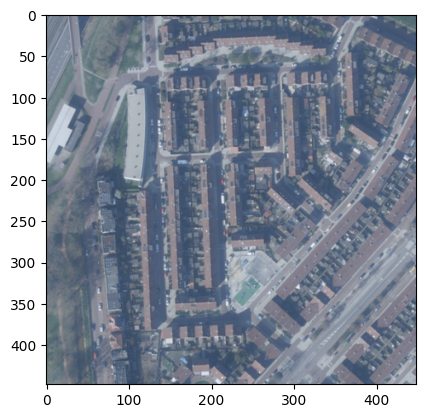

In [8]:
top_view = dataset.__getitem__(idx_)[1]
img_torch = top_view 

infer_model(img_torch,inference_dict['models'][1],"CE")

# Test

In [9]:
#--- Data 
input_path = "/mnt/hdd/eric/.tmp_ipy/00.Data/Map_Your_City/building-age-dataset/"
train_path = input_path + "train/data/"
test_path = input_path + "test/data/"
train_df = pd.read_csv(input_path + "train/train-set.csv")
test_df = pd.read_csv(input_path + "test/test-set.csv") 

#--- data split 
names_test = os.listdir(test_path)
names_test = sorted(names_test)

In [10]:
submit_df = pd.DataFrame(
    {"idx":[i for i in range(len(names_test))],
     "names_test":names_test,
     "street_veiw_exists":[False for i in range(len(names_test))],
     "street_view_prediction" :[0 for i in range(len(names_test))],
     "top_view_prediction" : [0 for i in range(len(names_test))]}
)

In [11]:
submit_df.head()

,idx,names_test,street_veiw_exists,street_view_prediction,top_view_prediction
0,0,22mhjewvtj,False,0,0
1,1,22pujdqtiu,False,0,0
2,2,23ykackznc,False,0,0
3,3,2435ikdnmf,False,0,0
4,4,24akvvheae,False,0,0


In [12]:
for ID in names_test:
    street_file_ = os.path.join( test_path + ID + '/street.jpg')
    if os.path.exists(street_file_):
        submit_df.loc[submit_df['names_test'] == ID, 'street_veiw_exists'] = True
        

In [13]:
submit_df.head()

,idx,names_test,street_veiw_exists,street_view_prediction,top_view_prediction
0,0,22mhjewvtj,True,0,0
1,1,22pujdqtiu,True,0,0
2,2,23ykackznc,False,0,0
3,3,2435ikdnmf,True,0,0
4,4,24akvvheae,False,0,0


In [14]:
street_view_names = submit_df.loc[submit_df['street_veiw_exists'] == True, 'names_test']
street_view_names = sorted(street_view_names)

In [15]:
len(street_view_names)

2167

In [16]:
test_set = map_dataset.Map_Dataset_v7(street_view_names,test_path,max_size=data_config['input_size'][1],cfg=cfg,split="test") 

In [17]:
'''
gather predictions of CE model 1

'''

model = inference_dict['models'][0]


from tqdm import tqdm 

batch_size = 8
TestLoader = DataLoader(test_set,batch_size,shuffle=False)

device = "cuda:3"

#-- Loader train/valid
Loader = TestLoader
#--
#labels_ = []
predictions_ = []
for batch in tqdm(Loader):
    imgs = batch[0].to(device)
    #lables = batch[-1]
    batch_preds = model(imgs)
    #predictions = torch.argmax(batch_preds,-1)
    
    #-- 
    predictions_.extend(batch_preds.detach().cpu())
    #labels_.extend(lables)

#---
inference_dict['predictions'].append(predictions_)
#inference_dict['labels'].append(labels_)


100%|██████████| 271/271 [01:24<00:00,  3.19it/s]


In [18]:
# A = {
#     "tensors" : [ i.softmax(-1) for i in predictions_]
# }

In [19]:
predictions_.__len__()

2167

In [20]:
# for name, pred in zip(street_view_names,predictions_):
#     print(name,pred)
#     submit_df.loc[submit_df['names_test'] == name, 'street_view_prediction'] = -1 

In [21]:
submit_df

,idx,names_test,street_veiw_exists,street_view_prediction,top_view_prediction
0,0,22mhjewvtj,True,0,0
1,1,22pujdqtiu,True,0,0
2,2,23ykackznc,False,0,0
3,3,2435ikdnmf,True,0,0
4,4,24akvvheae,False,0,0
...,...,...,...,...,...
4524,4524,zz33egthkw,False,0,0
4525,4525,zzfq447gpt,False,0,0
4526,4526,zzijnoebwv,True,0,0
4527,4527,zzphni4qma,True,0,0


In [22]:
len(street_view_names),len(predictions_)

(2167, 2167)

In [23]:
len(names_test)

4529

In [24]:
torch.cuda.empty_cache

<function torch.cuda.memory.empty_cache() -> None>

In [25]:
'''
gather predictions of CE model 2 

'''
test_set = map_dataset.Map_Dataset_v7(names_test,test_path,max_size=data_config['input_size'][1],cfg=cfg,
                                      split="test",test_mode="top_view_only") 
batch_size = 8
TestLoader = DataLoader(test_set,batch_size,shuffle=False)
Loader = TestLoader

model = inference_dict['models'][1]

#--
#labels_ = []
predictions_ = []
for batch in tqdm(Loader):
    imgs = batch[1].to(device)
    #lables = batch[-1]
    batch_preds = model(imgs)
    #predictions = torch.argmax(batch_preds,-1)
    
    #-- 
    predictions_.extend(batch_preds.detach().cpu())
    #labels_.extend(lables)

#---
inference_dict['predictions'].append(predictions_)
#inference_dict['labels'].append(labels_)

100%|██████████| 567/567 [02:06<00:00,  4.48it/s]


In [39]:
names_test[0:10]

['22mhjewvtj',
 '22pujdqtiu',
 '23ykackznc',
 '2435ikdnmf',
 '24akvvheae',
 '24d983q6sy',
 '24jyazdpcb',
 '25nnpektbr',
 '25wtfxzutb',
 '25xqvcygmf']

In [29]:
ce_model_confidence_1 = [i.softmax(-1).argmax(-1) for i in inference_dict['predictions'][1]]
print(len(ce_model_confidence_1))

4529


In [34]:
ce_model_confidence_1[0:5]

[tensor(4), tensor(5), tensor(3), tensor(0), tensor(0)]

In [31]:
df_s = test_df.sort_values(by=["pid"], ascending=[True]) 

In [33]:
df_s.head()

,country_id,pid,city_id
3997,QCD,22mhjewvtj,YPGHW
2557,QCD,22pujdqtiu,YPGHW
1770,FMW,23ykackznc,7PNBD
3119,QCD,2435ikdnmf,YPGHW
1491,FMW,24akvvheae,7PNBD


In [35]:
df_s['predicted_label'] = [i.numpy() for i in ce_model_confidence_1]

In [36]:
df_s

,country_id,pid,city_id,predicted_label
3997,QCD,22mhjewvtj,YPGHW,4
2557,QCD,22pujdqtiu,YPGHW,5
1770,FMW,23ykackznc,7PNBD,3
3119,QCD,2435ikdnmf,YPGHW,0
1491,FMW,24akvvheae,7PNBD,0
...,...,...,...,...
2104,FMW,zz33egthkw,7PNBD,0
726,PNN,zzfq447gpt,B2MVH,0
2904,QCD,zzijnoebwv,YPGHW,0
3667,QCD,zzphni4qma,YPGHW,1


In [37]:
submit_name = "topview_only_01"
df_s.to_csv(f"/mnt/hdd/eric/.tmp_ipy/15.Lab_Detection/07.Challenge/01.MapYourCity_HuggingFace/submissions/{submit_name}.csv")